# Strain-gauage ADCs: HX711, ADS1232, ADS1220 Comparison Test

<img width=300px align=right src=test_system.jpg> 
This comparison test is meant to find a decision key 
    for choosing the ADC among __HX711, ADS1232, and ADS1220__ for measurement of __strain gauge__.

The experiment focuses on the question about precision on each ADC.
Diffence between read values on same weight should be aware.

In experiment, the sensor, ADC, and microcontroller are connected as the system shown in the right figure.

<img width=300px align=left src=eqv_loadcell.jpg> 
These ADCs are designed to interface with such kind of sensor 
    which changes the output voltage slightly in comparison with the excitation voltage.
Thus, each of them has already been embedded a differential amplifier as the front-end
    to connect with an external __Wheatstone-bridge__ circuit integrated with the strain gauge.

The mentioned bridge circuit, as shown on the left figure, 
    has already been embedded in the device that is called __loadcell__.
In experiment, each of ADCs was connected with a loadcell and measured values of standard weights.

## Experiment

### Objective

* To compare the precision among HX711, ADS1232, and ADS1220.

### Setup

<img width=300px align=left src=testbed.jpg>
<img width=400px align=right src=../documents/imas_cjmcu_hx711_ads1232_ads1220.png>

In the left figure, 
    in spite of phototyping the board just for experimentation, 
    the testbed was powerred by lab-graded power supply due to the measurment quality.

The __schematic__ shown on the right explains the prototype circuit on the left.

<img width=300px align=right src=standard_weights.jpg>

The loadcell used in this test plays a part as scale, as shown in the figure on the right.
Standard weights: __5, 10, 20, 50, and 100 grams__ were read by the ADCs under test.
Each weight were __measured 20 times__ for examining precision of each ADCs throught __mean and varience__ calculations.

### Method

1. Experiment each ADC by __connecting__ the __only one loadcell__ to one of ADC: HX711, ADS1232, and ADS1220.
1. __Calibrate__ the connected system with __100g standard weight__.
1. __Read__ the value from ADC __20 times__.

### Result

In [ ]:
x-special/nautilus-clipboard
cut
file:///home/ipas/Dat/NECTEC/20200323_Structure_Monitoring_with_SIIT_Lab/test-structure-health-monitoring-project/experiment/ADS1220.txt
file:///home/ipas/Dat/NECTEC/20200323_Structure_Monitoring_with_SIIT_Lab/test-structure-health-monitoring-project/experiment/ADS1232.txt
file:///home/ipas/Dat/NECTEC/20200323_Structure_Monitoring_with_SIIT_Lab/test-structure-health-monitoring-project/experiment/HX711.txt


#### Script

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import pandas as pd
import matplotlib, datetime
import matplotlib.pyplot as plt

In [3]:
matplotlib.rc('text', usetex=True)
matplotlib.rc('font',**{'family':'sans-serif', 'sans-serif':['Times New Roman'], 'size':10})

In [4]:
def get_data_from_file(filename):
    f = open(filename, 'r')
    data = []
    re_temp = re.compile(r'temp=(?P<cpu>[0-9.]+).*, .*=(?P<air>[0-9.]+).*, (?P<timestamp>[0-9\-: ]+)')
    line = f.readline()
    while line:
        line = f.readline() # Already skipped the first line
        found = re_temp.search(line)
        if found is not None:
            data.append(found.groupdict())
    return data

In [5]:
def make_df_from_file(filename):
    df = pd.DataFrame(get_data_from_file(filename))
    df['cpu'] = pd.to_numeric(df['cpu'])
    df['air'] = pd.to_numeric(df['air'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = pd.to_datetime(df['timestamp'] - df['timestamp'][0])  # Make time diff
    #df['timestamp'] = pd.to_timedelta(df['timestamp'].dt.total_seconds(), unit='s')
    df['timestamp'] = df['timestamp'].dt.time  # only time shown
    df = df.set_index('timestamp')
    return df

In [6]:
def plot_result(df, title_suffix='', **kwargs):
    ax = df.plot(title='Stress Test'+title_suffix, grid=True, color='brgk', **kwargs) #, figsize=(14,8))
    ax.set_xlabel('Time HH:mm:ss')
    ax.set_ylabel('$^{\circ}$C')

#### Data

In [7]:
flog_open = 'stress_2020-01-06 09:06:50_open.log'
flog_close = 'stress_2020-01-06 09:33:01_close.log'
flog_flowin = 'stress_2020-01-06 10:10:30_close_flow_in.log'
flog_flowout = 'stress_2020-01-06 09:49:53_close_flow_out.log'

In [8]:
df_open = make_df_from_file(os.path.join('rpi/log_jan', flog_open))
df_close = make_df_from_file(os.path.join('rpi/log_jan', flog_close))
df_flowin = make_df_from_file(os.path.join('rpi/log_jan', flog_flowin))
df_flowout = make_df_from_file(os.path.join('rpi/log_jan', flog_flowout))

#### Temperature Trends

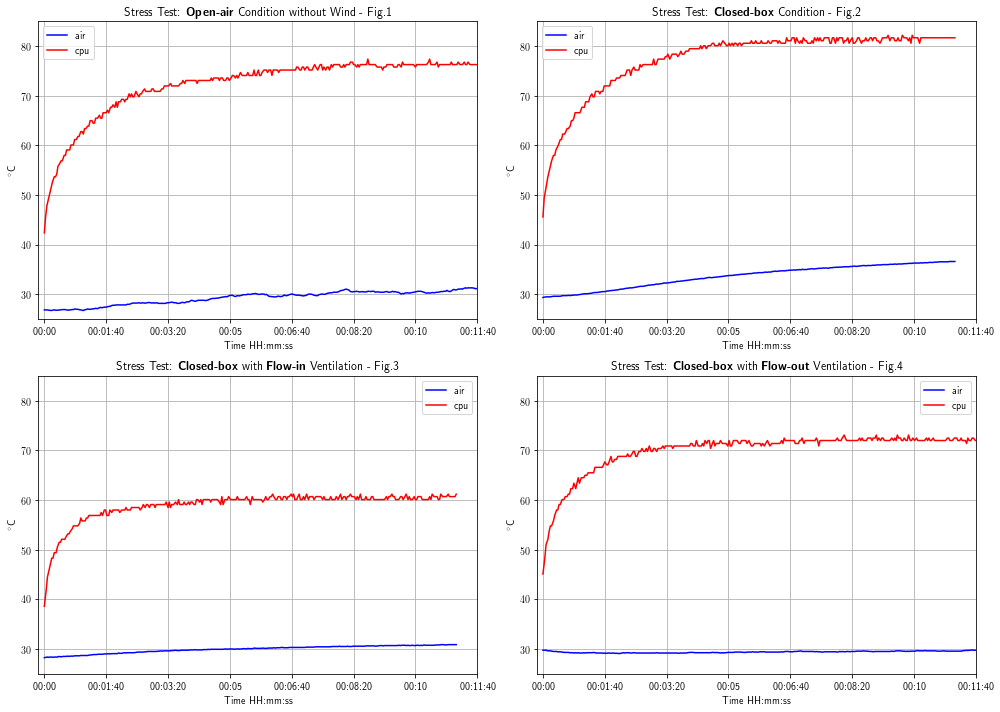

In [9]:
fig = plt.figure(figsize=(14,10))

for i, (df, suffix) in enumerate([(df_open,    r': \textbf{Open-air} Condition without Wind - Fig.%d'),
                                  (df_close,   r': \textbf{Closed-box} Condition - Fig.%d'),
                                  (df_flowin,  r': \textbf{Closed-box} with \textbf{Flow-in} Ventilation - Fig.%d'), 
                                  (df_flowout, r': \textbf{Closed-box} with \textbf{Flow-out} Ventilation - Fig.%d'),
                                 ]):
    ax = plt.subplot('22%d' % (i+1))
    plot_result(df, title_suffix=suffix % (i+1), ax=ax)
    ax.set_xlim([-10, 700])
    ax.set_ylim([25, 85])

plt.tight_layout()

#### Comparison

In [10]:
df_cpu_comparison = pd.concat([df_open['cpu'].rename('open'), 
                               df_close['cpu'].rename('close'),
                               df_flowin['cpu'].rename('flowin'),
                               df_flowout['cpu'].rename('flowout')], axis=1, sort=True)

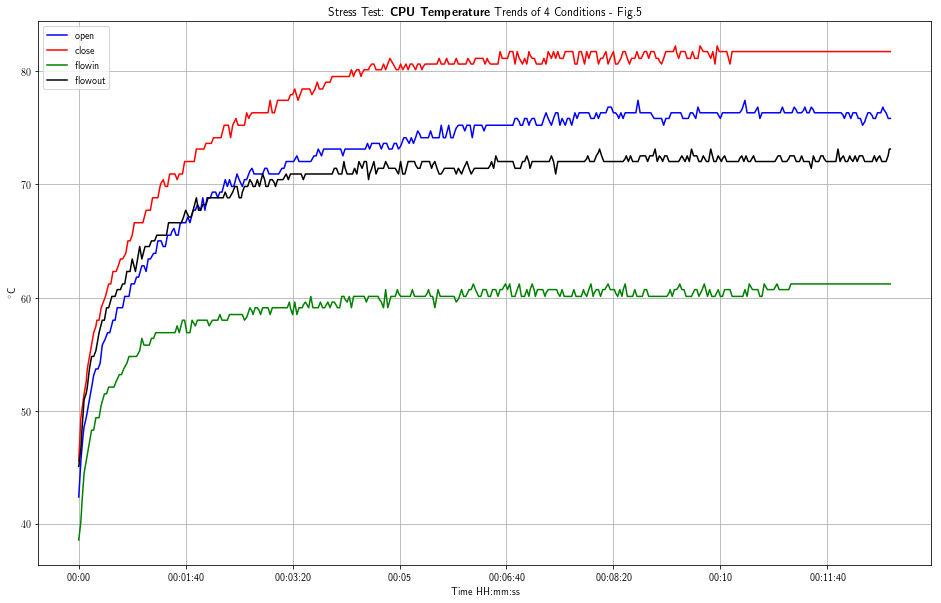

In [11]:
plot_result(df_cpu_comparison.interpolate(), title_suffix=r': \textbf{CPU Temperature} Trends of 4 Conditions - Fig.5', figsize=(16,10))

In [12]:
df_cpu_comparison.head(n=3)

,open,close,flowin,flowout
00:00:00,42.4,45.6,38.6,45.1
00:00:02,45.6,49.4,NaN,NaN
00:00:03,NaN,NaN,41.9,48.3


In [13]:
df_cpu_comparison.interpolate().tail(n=2)

,open,close,flowin,flowout
00:12:38,75.8,81.7,61.2,73.1
00:12:39,75.8,81.7,61.2,73.1


## Conclustion

Each test was done about __10 minutes__ until the operating temperature approached steady level.
The DUT worked well __without crash__.

<table>
    <tr>
        <td> 
            <b>Open-air
        <td>
            <b>Closed box
        <td>
            <b>Closed box with Flow-in Ventilation
        <td>
            <b>Closed box with Flow-out Ventilation
    <tr>
        <td width=25%><img src=fig/20200106_163054_open.png>
        <td width=25%><img src=fig/20200106_164007_close.jpg>
        <td width=25%><img src=fig/20200106_170222_flow-in.png>
        <td width=25%><img src=fig/20200106_170140_flow-out.png>
    <tr>
        <td>
            Normally the CM3's temperature is about <b>42.4°C in idle state</b>.
            The temperature approached <b>75.8°C at most</b>.
        <td>
            Normally the CM3's temperature is about <b>45.6°C in idle state</b>.
            The temperature approached <b style="color:red;">81.7°C at most</b>.
        <td>
            Normally the CM3's temperature is about <b style="color:green">38.6°C in idle state</b>.
            The temperature approached <b style="color:green">61.2°C at most</b>.
        <td>
            Normally the CM3's temperature is about <b>45.1°C in idle state</b>.
            The temperature approached <b>73.1°C at most</b>.
</table>

With the __same graphical computing operation__, the tests were done on 4 conditions of Raspberry-Pi CM3 resided on J-RTU.
Quality of heat transfer out of CM3's CPU, is revealed from data.

The result shows that CM3's CPU heat dissipation will be improved if the convection is increased.
The CPU with __higher air-convection has lower temperature__ than the others, as shown in figure 5.

In addition, even if surrounding temperature is a little lower,
    the CPU temperature in figure 4 is more over than 10°C, compared to figure 3.
That is because of the better air-convection
    where the __intake air-flow passes through the CPU__ with higher constant rate.

## Addendum

### Future Works

* N-time experiment
* Days-and-weeks experiment 
* Crash recording
* RAM & eMMC temperatures collecting 
* Heat-conduction technique

### Testing Script: Stress Test & Getting CPU Temperature

```bash
pids=()

## CPU stress test
stress-ng --cpu 4 --cpu-load 100 --timeout 1y  &
#pids=( "${pids[@]}" $! )
pids+=( $! )


## GPU test
omxplayer --loop --fps 30 --win '0 0 960 540' --alpha 128 test.mp4  &
pids+=( $! )


## iperf server
iperf_server() {
	while true; do iperf -s; sleep 1; done; 
}
#iperf_server  &
pids+=( $! )


## iperf client
iperf_client() {
	while true; do iperf -c 127.0.0.1 -b 10M -t 60; sleep 1; done;
}
#iperf_client  &
pids+=( $! )


echo 'All jobs:' ${pids[@]}
die() {
	kill ${pids[@]}
	exit 0
}
trap die SIGINT SIGTERM

while true; do vcgencmd measure_temp; sleep 1; done;
```

### Testing Script: Getting Air Temperature

```python
import os
import glob
import time

# os.system('modprobe w1-gpio')
# os.system('modprobe w1-therm')

base_dir = '/sys/bus/w1/devices/'
device_folder = glob.glob(base_dir + '28*')[0]
device_file = device_folder + '/w1_slave'
 
def read_temp_raw():
    f = open(device_file, 'r')
    lines = f.readlines()
    f.close()
    return lines

def read_temp():
    lines = read_temp_raw()
    while lines[0].strip()[-3:] != 'YES':
        time.sleep(0.2)
        lines = read_temp_raw()
    equals_pos = lines[1].find('t=')
    if equals_pos != -1:
        temp_string = lines[1][equals_pos+2:]
        temp_c = float(temp_string) / 1000.0
        temp_f = temp_c * 9.0 / 5.0 + 32.0
        return {'C':temp_c, 'F':temp_f}

temps = read_temp()
print '{}={}\'C'.format(device_file, temps['C'])
```

---